In [23]:
%matplotlib inline

import geopandas
import regionmask

import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import os

from loca.data_catalog import load_monthly_cmip_hydro_datasets, resample_monthly_data
from loca.utils import calc_change

In [24]:
# create GeoDataFrame with all HUC2 elements
# huc 2 to 4, should WBDHU2.shp
dfs = []
hucs = list(range(1, 19))
for i in hucs:
    huc2_file = f'/glade/u/home/jhamman/projects/storylines/data/gis/WBD_{i:02d}_Shape/Shape/WBDHU2.shp'
    gdf = geopandas.GeoDataFrame.from_file(huc2_file)
    dfs.append(gdf)
gdf = pd.concat(dfs)
gdf.index = hucs
gdf.head()

,TNMID,METASOURCE,SOURCEDATA,SOURCEORIG,SOURCEFEAT,LOADDATE,GNIS_ID,AREAACRES,AREASQKM,STATES,HUC2,NAME,SHAPE_LENG,SHAPE_AREA,geometry
1,{87290825-BAC9-4D07-8A32-E35A873C0BD1},None,None,None,None,20170816000649,2730131,49135499.18,198844.49,"CN,CT,MA,ME,NH,NY,RI,VT",01,New England Region,48.2984344819978,22.4854347168858,(POLYGON ((-73.02573148771478 41.2130396099875...
2,{4AEF9DDF-A9C6-400E-8FD8-180FD5C29F69},None,None,None,None,20170816000624,2730132,68320130.43,276482,"CT,DC,DE,MA,MD,NJ,NY,PA,RI,VA,VT,WV",02,Mid Atlantic Region,52.4177510650764,29.2456409326581,(POLYGON ((-73.0255572637567 41.21326637769545...
3,{9C77B5BA-946A-4537-BADD-990373DEFFBB},None,None,None,None,20170801122959,2730133,182774403.26,739662.42,"AL,FL,GA,LA,MS,NC,SC,TN,VA",03,South Atlantic-Gulf Region,69.8844227515357,71.0064380485419,"POLYGON ((-79.4782105318659 37.50766332823895,..."
4,{EBD12DC7-3886-4A92-BF58-E3147628761B},None,None,None,None,20170807182410,2730134,152474968.05,617044.85,"CN,IL,IN,ME,MI,MN,NH,NY,OH,PA,VT,WI",04,Great Lakes Region,166.233809505139,70.0158950771809,POLYGON ((-88.00263874050927 49.02244801140739...
5,{5C6AE09C-4CFC-4EBA-9344-A91AF35E73E8},None,None,None,None,20170627161550,2730135,104270021.21,421966.18,"IL,IN,KY,MD,NC,NY,OH,PA,TN,VA,WV",05,Ohio Region,61.3943869537108,43.813407644068,"POLYGON ((-79.03733301900854 42.4486251580696,..."


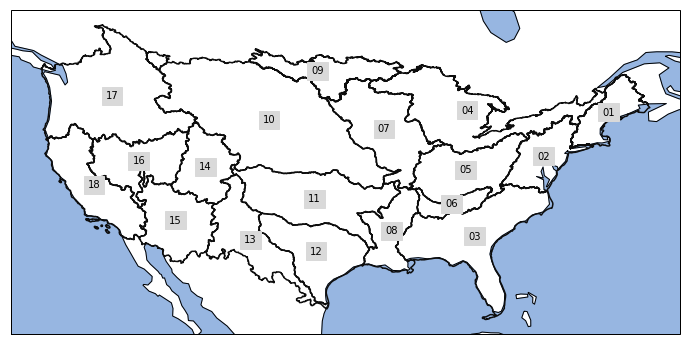

In [25]:
plt.figure(figsize=(12, 8))
# Create a Regions object for masking
huc_mask = regionmask.Regions_cls('USmask', range(len(gdf)), gdf.HUC2.values, list(map(str, hucs)), gdf.geometry.values)
# https://regionmask.readthedocs.io/en/stable/generated/regionmask.Regions_cls.html
huc_mask.plot(label='name')

plt.savefig('hucs.png', dpi=300)
# to save figure, do shift and two figure click... though it'd be nice to do this with plt.savefig(), though as it isn't plotted in matplotlib, unsure how to do this

In [26]:
from dask.distributed import Client
client = Client(scheduler_file=os.path.join(os.environ['HOME'], 'scheduler_file.json'))
client

Client Scheduler: tcp://10.148.10.13:54887 Dashboard: proxy/8787/status,Cluster Workers: 36 Cores: 144 Memory: 180.00 GB


In [27]:
# client.restart()

distributed.client - ERROR - Restart timed out after 20.000000 seconds


Client Scheduler: tcp://10.148.10.13:54887 Dashboard: proxy/8787/status,Cluster Workers: 27 Cores: 108 Memory: 135.00 GB


In [28]:
read_cache = True
hist_data = {}
rcp4_data = {}
rcp8_data = {}
if read_cache:
    for key in ['loca', 'bcsd']:
        hist_data[key] = xr.open_mfdataset(
            os.path.join(os.environ['TMPDIR'], f'monthly_cmip_hydro_hist.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})
        rcp4_data[key] = xr.open_mfdataset(
            os.path.join(os.environ['TMPDIR'], f'monthly_cmip_hydro_rcp4.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})
        rcp8_data[key] = xr.open_mfdataset(
            os.path.join(os.environ['TMPDIR'], f'monthly_cmip_hydro_rcp8.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})
print("read from path")
os.path.join(os.environ['TMPDIR'])

read from path


'/glade/scratch/jvano/temp'

In [67]:
# display (hist_data)

Object `display (hist_data)` not found.


In [30]:
write_mask = False  #writing the mask takes about 20 mins for each key, value currently stashed bcsd (but easy to rewrite)

if write_mask:
    for key in ['loca']:
        monthly = hist_data[key].groupby('time.month').mean('time').load()  # TODO test (streamlined)
        huc_mask = regionmask.Regions_cls('USmask', range(len(gdf)), gdf.HUC2.values, list(map(str, hucs)), gdf.geometry.values)  # TODO test (streamlined)
        mask = huc_mask.mask(monthly, wrap_lon=False)
        display (mask)
        mask.plot()
        mask.load().to_netcdf(os.path.join(os.environ['TMPDIR'], f'mask.{key}.nc'))

In [31]:
type(hist_data['loca'])

xarray.core.dataset.Dataset

In [61]:
monthly = {}
data_by_huc = {}
hydro_var = 'total_runoff'
for key in ['loca', 'bcsd']:
    monthly[key] = hist_data[key].groupby('time.month').mean('time').load()
    mask = xr.open_dataarray(os.path.join(os.environ['TMPDIR'], f'mask.{key}.nc'))
    # Group data by huc
    data_by_huc[key] = monthly[key].groupby(mask).mean('stacked_lat_lon')
    display(data_by_huc[key])
    data_by_huc_ens_mean[key] = data_by_huc[key][hydro_var].mean('gcm')
    display(data_by_huc_ens_mean[key]) 

<xarray.Dataset>
Dimensions:       (gcm: 25, month: 12, region: 18)
Coordinates:
  * gcm           (gcm) <U14 'ACCESS1-0' 'CCSM4' ... 'bcc-csm1-1' 'inmcm4'
  * month         (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * region        (region) float64 0.0 1.0 2.0 3.0 4.0 ... 14.0 15.0 16.0 17.0
Data variables:
    ET            (region, month, gcm) float32 10.627242 10.493171 ... 14.83039
    total_runoff  (region, month, gcm) float32 30.951822 32.01066 ... 23.09472
    SWE           (region, month, gcm) float32 100.262764 ... 22.576174

<xarray.DataArray 'loca' (region: 18, month: 12)>
array([[30.801304, 24.67332 , 42.92213 , ..., 24.5802  , 36.05272 , 40.04193 ],
       [40.552475, 39.220173, 55.29956 , ..., 24.86466 , 29.747704, 38.542732],
       [49.48486 , 51.487133, 59.86757 , ..., 34.32248 , 30.677034, 38.196003],
       ...,
       [ 2.171188,  2.666393,  4.281734, ...,  1.83438 ,  1.985299,  1.813027],
       [35.15326 , 33.148006, 38.73314 , ..., 19.842   , 28.534544, 33.08507 ],
       [37.78699 , 40.328987, 44.071445, ...,  3.528945, 11.085823, 22.546446]],
      dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * region   (region) float64 0.0 1.0 2.0 3.0 4.0 ... 13.0 14.0 15.0 16.0 17.0

<xarray.Dataset>
Dimensions:       (gcm: 25, month: 12, region: 18)
Coordinates:
  * gcm           (gcm) <U14 'ACCESS1-0' 'CCSM4' ... 'bcc-csm1-1' 'inmcm4'
  * month         (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * region        (region) float64 0.0 1.0 2.0 3.0 4.0 ... 14.0 15.0 16.0 17.0
Data variables:
    ET            (region, month, gcm) float32 17.73674 18.21078 ... 12.3266325
    total_runoff  (region, month, gcm) float32 42.703835 42.10324 ... 28.125769
    SWE           (region, month, gcm) float32 45.75851 48.005398 ... 8.432977

<xarray.DataArray 'bcsd' (region: 18, month: 12)>
array([[41.949184, 35.128544, 57.516937, ..., 29.067223, 46.99948 , 51.998703],
       [48.184746, 46.39659 , 59.75983 , ..., 24.155512, 33.173206, 45.4129  ],
       [55.962543, 58.739204, 64.9302  , ..., 37.262314, 33.847946, 43.011314],
       ...,
       [ 2.673176,  2.975489,  4.900002, ...,  2.019424,  2.15158 ,  2.084733],
       [37.463066, 36.098305, 40.600502, ..., 20.82187 , 27.843594, 33.796078],
       [46.444103, 47.620922, 44.542328, ...,  3.807875, 10.685852, 25.476717]],
      dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * region   (region) float64 0.0 1.0 2.0 3.0 4.0 ... 13.0 14.0 15.0 16.0 17.0

In [62]:
# data_by_huc['bcsd']['total_runoff'].isel(region=0).mean('gcm').plot()
# display (lookup.index)

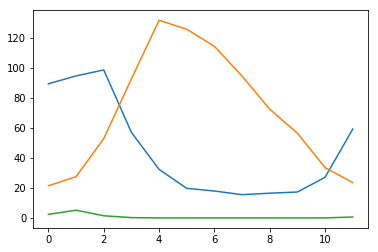

In [41]:
hydro_vars = ['ET', 'total_runoff', 'SWE']

i = 5
region = i

plt.plot(data_by_huc['bcsd']['total_runoff'].isel(region=i).mean('gcm'))
plt.plot(data_by_huc['bcsd']['ET'].isel(region=i).mean('gcm'))
plt.plot(data_by_huc['bcsd']['SWE'].isel(region=i).mean('gcm'))

In [66]:
# data_by_huc_ens_mean = data_by_huc['bcsd'].isel(region).mean('gcm')
# display (data_by_huc)

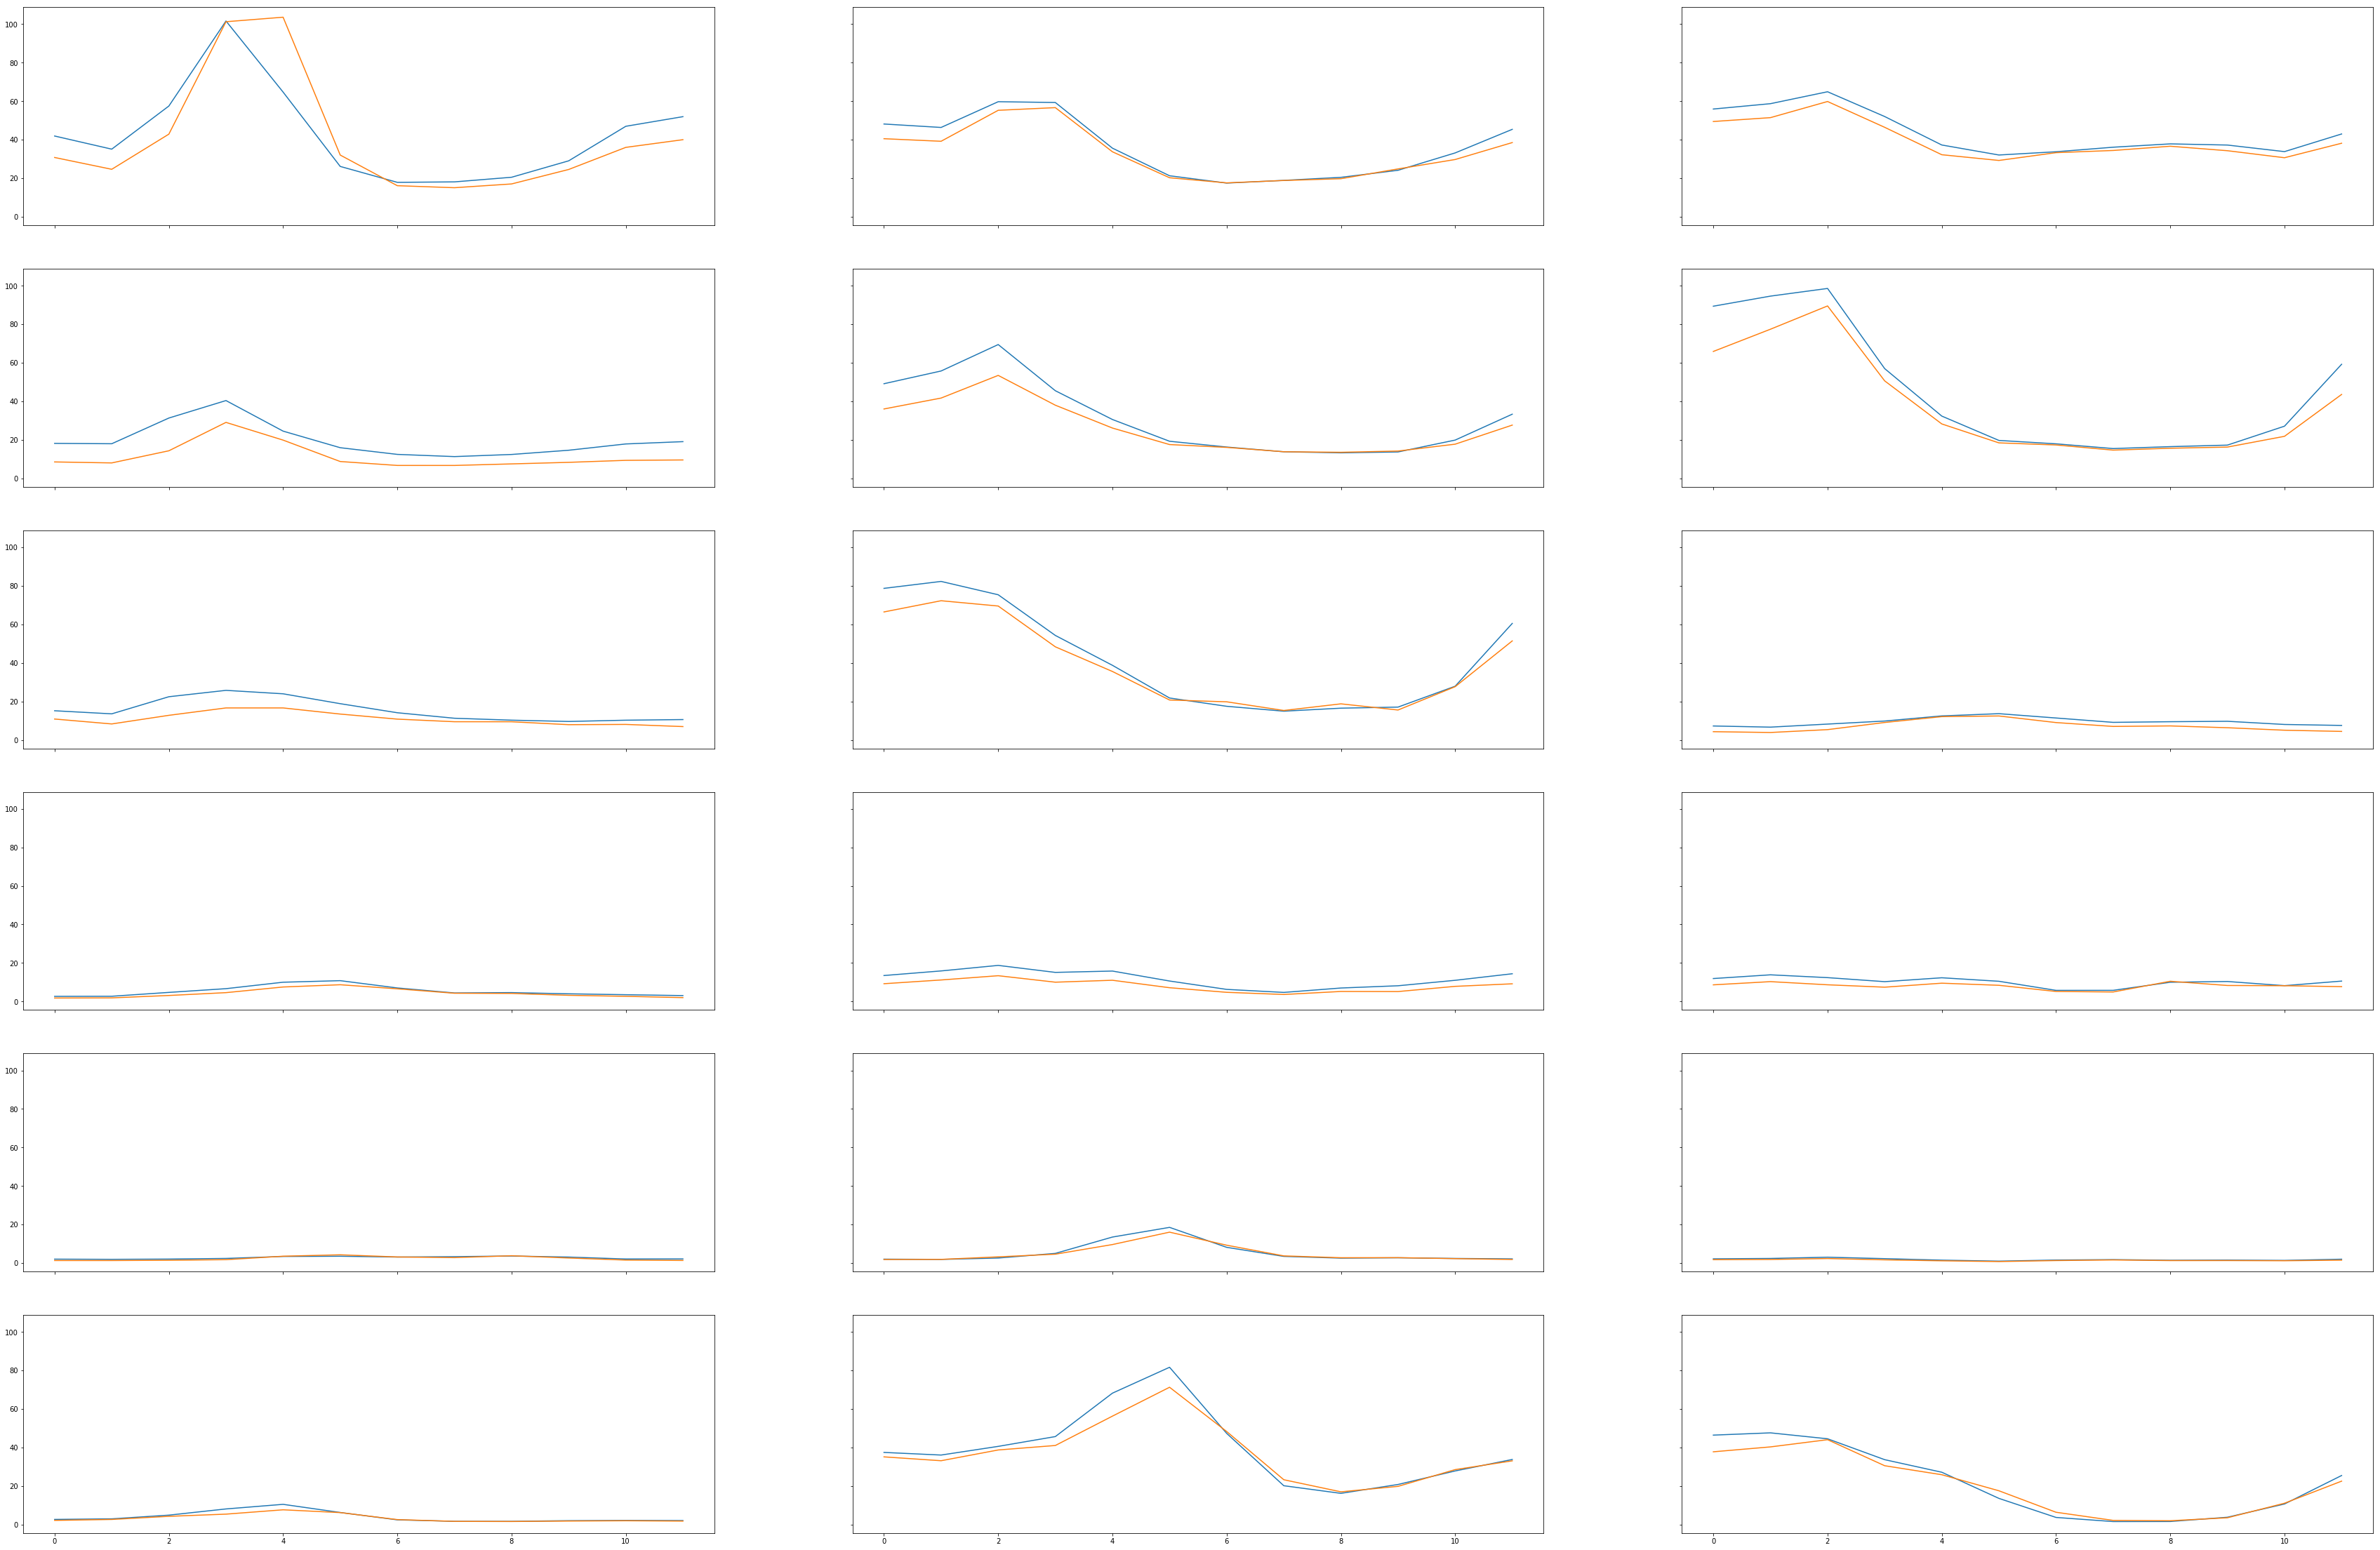

In [65]:
fig, axes = plt.subplots(ncols=3, nrows=6, sharex=True, sharey=True, figsize=(60, 40), squeeze=False)

lookup = gdf
staid = []
# display (data_by_huc)

# for i, (staid, row) in enumerate(lookup.iterrows()):
for i, (staid, row) in enumerate(lookup.iterrows()):
    plt.sca(axes.flat[i])
    plt.plot(data_by_huc_ens_mean['bcsd'].isel(region=i))
    plt.plot(data_by_huc_ens_mean['loca'].isel(region=i)) 

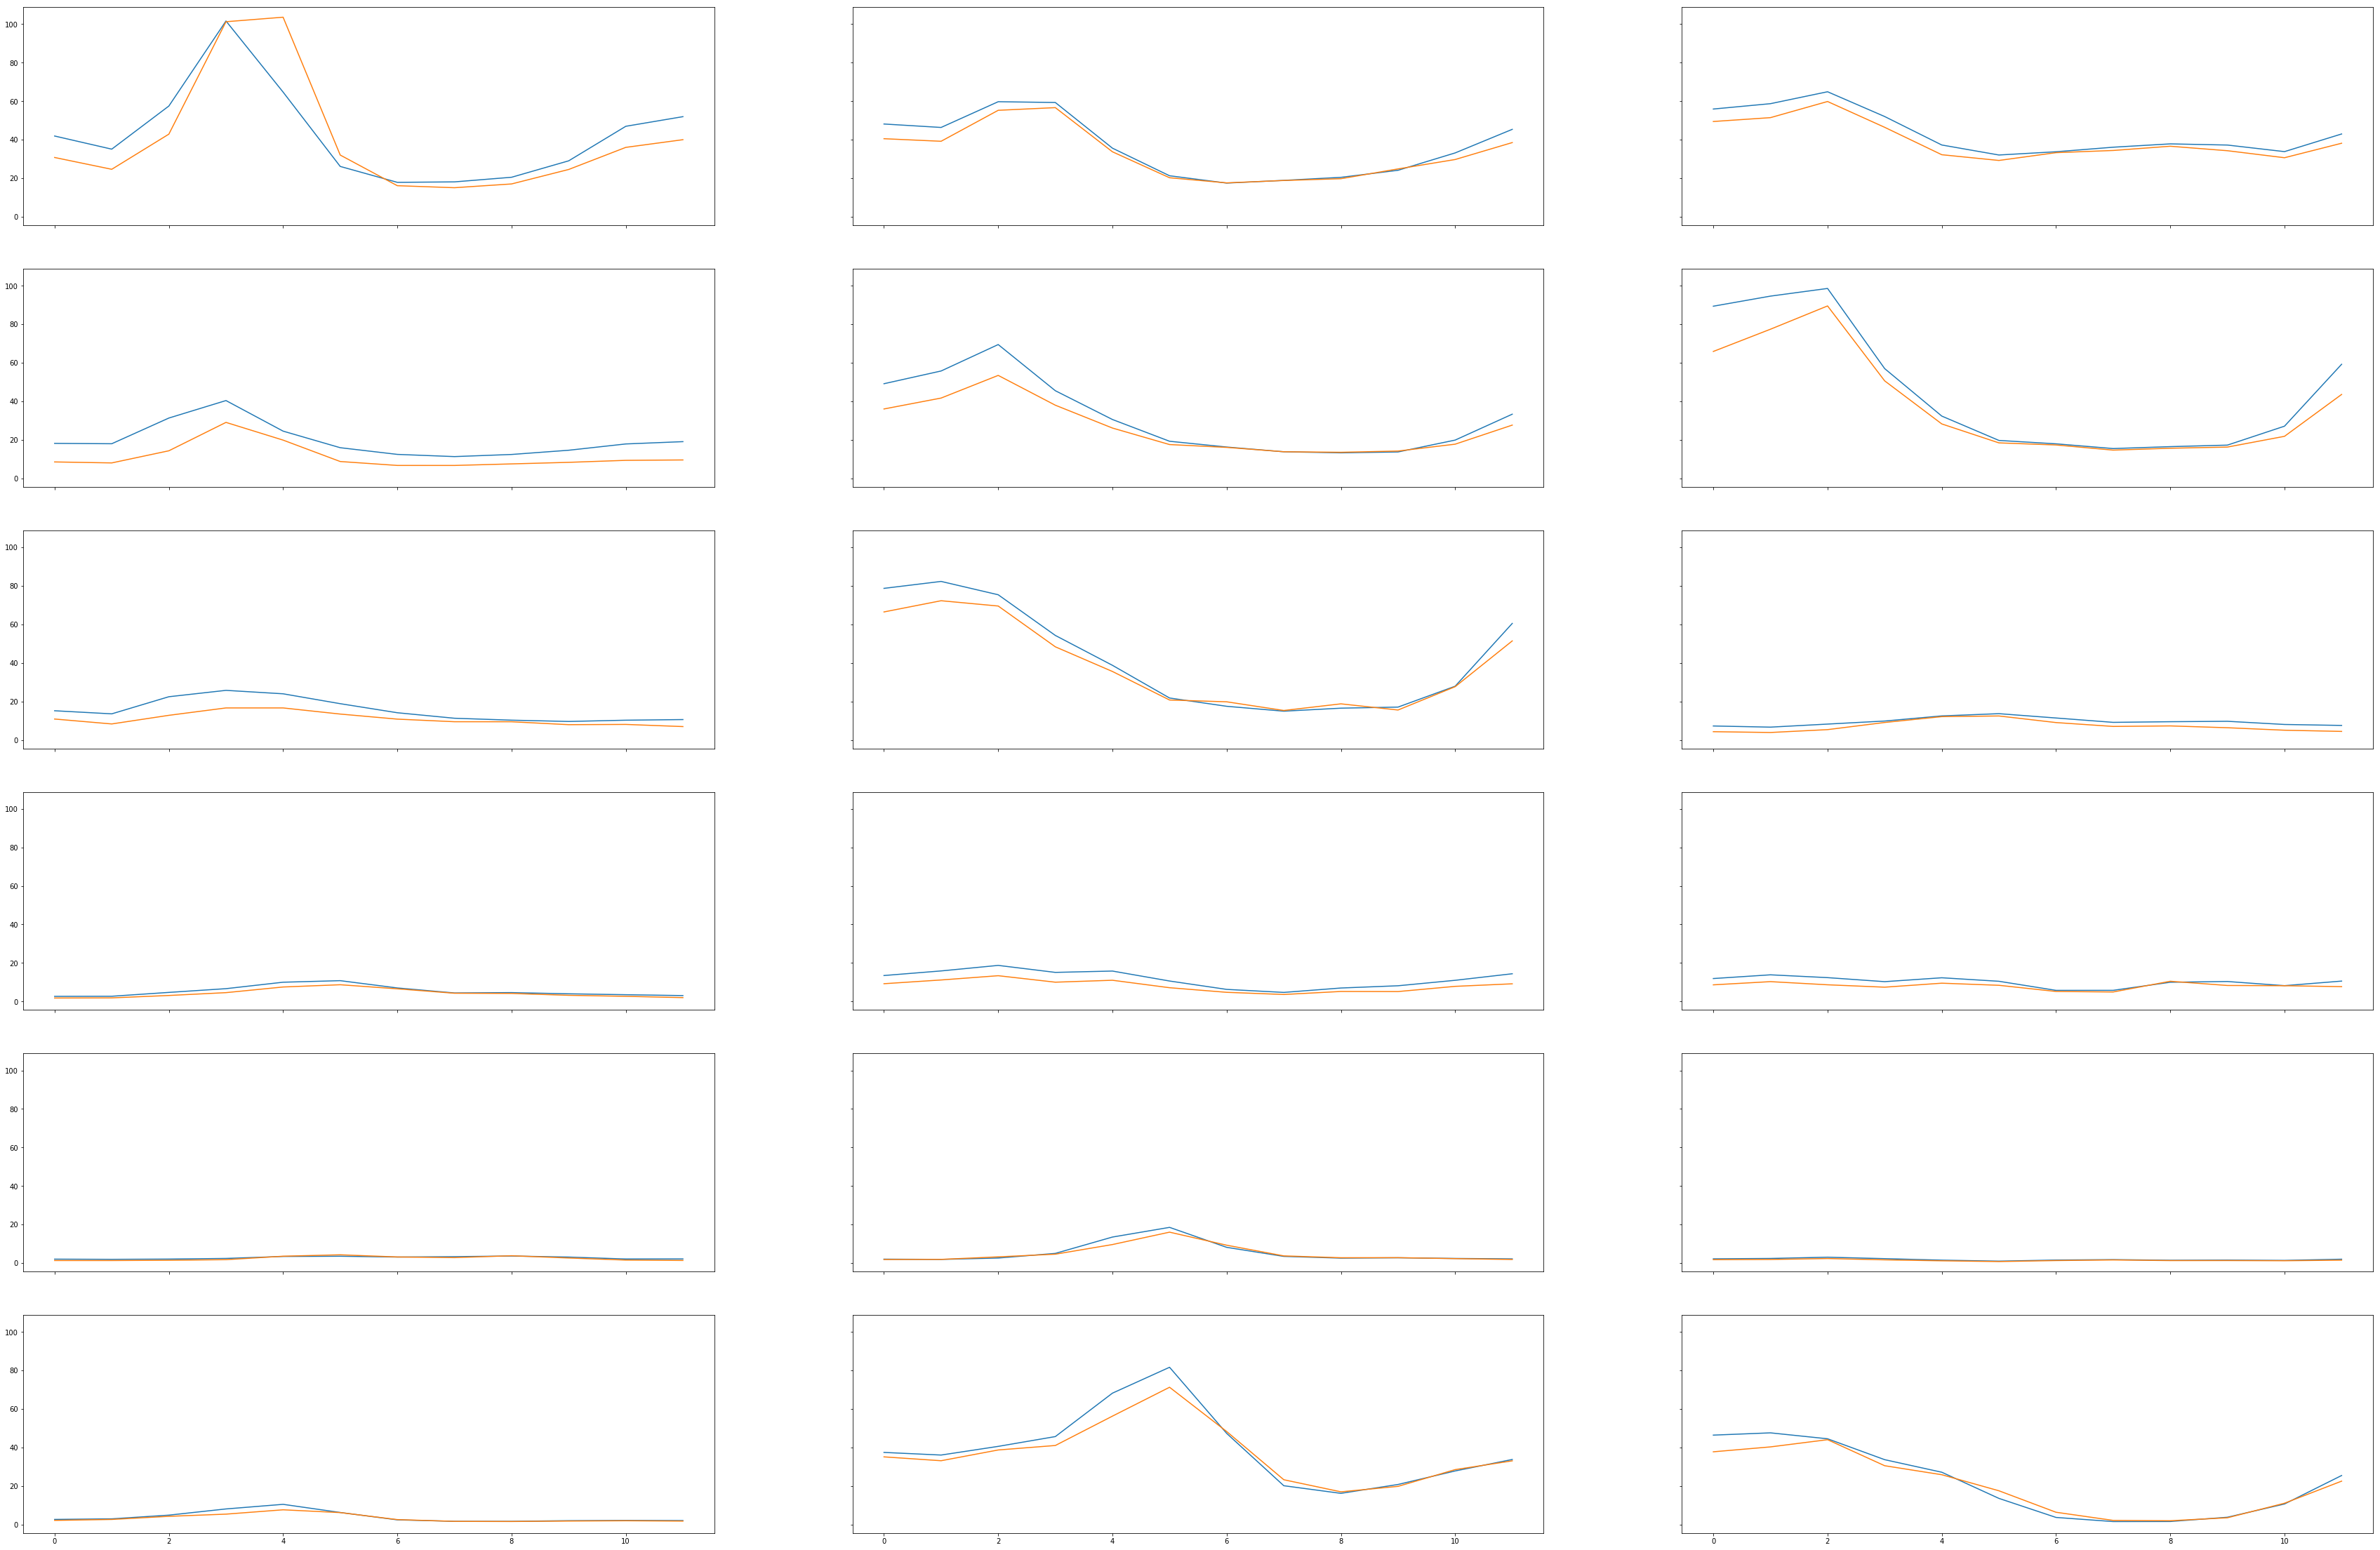

In [45]:
#OLDER

fig, axes = plt.subplots(ncols=3, nrows=6, sharex=True, sharey=True, figsize=(60, 40), squeeze=False)

lookup = gdf
staid = []
# display (data_by_huc)


# for i, (staid, row) in enumerate(lookup.iterrows()):
for i, (staid, row) in enumerate(lookup.iterrows()):
    plt.sca(axes.flat[i])
    plt.plot(data_by_huc['bcsd']['total_runoff'].isel(region=i).mean('gcm'))
    plt.plot(data_by_huc['loca']['total_runoff'].isel(region=i).mean('gcm'))  #best to do this calculation elsewhere? (moved up, see fig above)

# fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/huc{key}.png', bbox_inches='tight', dpi=100)

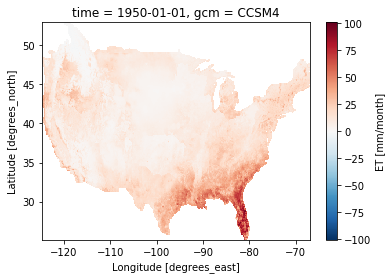

In [47]:
hist_data['bcsd']['ET'].isel(time=0, gcm=1).plot()

In [48]:
loca = hist_data['loca'].isel()
display(loca)

<xarray.Dataset>
Dimensions:       (gcm: 25, lat: 224, lon: 464, time: 672)
Coordinates:
  * time          (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2005-12-01
  * lat           (lat) float64 25.06 25.19 25.31 25.44 ... 52.69 52.81 52.94
  * lon           (lon) float64 -124.9 -124.8 -124.7 ... -67.31 -67.19 -67.06
  * gcm           (gcm) <U14 'ACCESS1-0' 'CCSM4' ... 'bcc-csm1-1' 'inmcm4'
Data variables:
    ET            (gcm, time, lat, lon) float32 dask.array<shape=(25, 672, 224, 464), chunksize=(1, 72, 224, 464)>
    total_runoff  (gcm, time, lat, lon) float32 dask.array<shape=(25, 672, 224, 464), chunksize=(1, 72, 224, 464)>
    SWE           (gcm, time, lat, lon) float32 dask.array<shape=(25, 672, 224, 464), chunksize=(1, 72, 224, 464)>

In [ ]:
wy_median = data_by_huc.mean('gcm')
display (wy_median)

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

wy_median = data_by_huc

# twy[range(startyr, endyr)].plot(c='lightgray', legend=False, ax=ax)
#twy[special_years].plot(legend=True, ax=ax)
wy_median.plot(c='black', legend=True, linewidth=2, ax=ax, fontsize=16)

# name = reservoir.loc["name","%s" % (location)]
plt.xlabel("day of water year", fontsize=24)
plt.ylabel("cfs", fontsize=20)
plt.title('Flows for %s Reservior (%i-%i, %s)' % (name, startyr, endyr, ts_name), fontsize=20)
plt.rc('legend', fontsize=12) 
ax.set_ylim([0, reservoir.loc["hydro_height","%s" % (location)]])

plt.savefig('%s/%s_%s_hydrograph_%i-%i.pdf' % (filepathfigs, name, ts_name, startyr, endyr))

KeyError: 'time'